In [1]:
#####Variable order Tensor Decomposition#####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [2]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no, pattern):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id
    if pattern==1:
        Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
        return z_id, Z

In [3]:
####データの発生####
##データの設定
#要素ごとのユニーク数を設定
k = 10
hh = 5000
item = 2500
subject = 700
element = 500
type_n = [item, subject, element]
max_m = 8
k_vec = np.repeat(1, k)
m_vec = np.repeat(1, max_m)

#要素ごとの頻度を生成
pt = np.random.poisson(np.random.gamma(20.0, 1/0.1, hh))
N = np.sum(pt)
m = np.random.poisson(2.75, N)
m[m==0] = 1; m[m >= max_m] = max_m
M = np.sum(m)

In [4]:
##idとインデックスの設定
#idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))
m_id = np.repeat(np.arange(N), m)

#インデックスの設定
freq_m = np.repeat(0, hh)
d_index = [i for i in range(hh)]
m_index = [i for i in range(N)]
for i in range(hh):
    d_index[i] = np.array(np.where(d_id==i)[0], dtype="int")
    freq_m[i] = np.sum(m[d_index[i]])
for i in range(N):
    if i==0:
        m_index[i] = np.arange(m[0])
    else:
        m_index[i] = np.max(m_index[i-1]) + np.arange(m[i]) + 1
freq_id = np.repeat(np.arange(hh), freq_m)

In [5]:
##アイテムの生成
#多項分布からトピックを生成
topic = 25
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
z = np.array(rmnom(theta_topic[freq_id, ], M, topic, np.arange(M), 0), dtype="int")

#アイテムの生成確率を設定
phi_item = np.random.dirichlet(np.repeat(0.1, item), topic)
phi_subject = np.random.dirichlet(np.repeat(0.1, subject), topic)
phi_element = np.random.dirichlet(np.repeat(0.1, element), topic)

#トピックからアイテムを生成
item_long = np.repeat(0, M)
subject_long = np.repeat(0, M)
element_long = np.repeat(0, M)
for j in range(topic):
    index = np.array(np.where(z==j)[0], dtype="int")
    target_z = z[index]
    topic_n = index.shape[0]
    item_long[index] = np.array(rmnom(phi_item[target_z, ], topic_n, item, np.arange(topic_n), 0), dtype="int")
    subject_long[index] = np.array(rmnom(phi_subject[target_z, ], topic_n, subject, np.arange(topic_n), 0), dtype="int")
    element_long[index] = np.array(rmnom(phi_element[target_z, ], topic_n, element, np.arange(topic_n), 0), dtype="int")
gc.collect()

#アイテムをレコードに割当
item_dt = np.full((N, max_m), item, dtype="int16")
subject_dt = np.full((N, max_m), subject, dtype="int16")
element_dt = np.full((N, max_m), element, dtype="int16")
for i in range(N):
    item_dt[i, np.arange(m[i])] = item_long[m_index[i]]
    subject_dt[i, np.arange(m[i])] = subject_long[m_index[i]]
    element_dt[i, np.arange(m[i])] = element_long[m_index[i]]
    
#一定確率で欠損を挿入
subject_dt[np.random.binomial(1, 0.5, N*max_m).reshape(N, max_m)==1] = subject
element_dt[np.random.binomial(1, 0.3, N*max_m).reshape(N, max_m)==1] = element

#観測インデックスを作成
z_index = [j for j in range(max_m)]
item_z = [j for j in range(max_m)]
subject_z = [j for j in range(max_m)]
element_z = [j for j in range(max_m)]
for j in range(max_m):
    z_index[j] = np.array(np.where(item_dt[:, j]!=item)[0], dtype="int")
    item_z[j] = item_dt[z_index[j], j]
    subject_z[j] = subject_dt[z_index[j], j]
    element_z[j] = element_dt[z_index[j], j]
Z = np.array(item_dt!=item, dtype="int8")

In [6]:
##応答変数を生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #事前分布のパラメータを設定
    alpha1 = np.array([0])
    alpha2 = np.repeat(0, k)
    tau_d = np.array([0.7])
    Cov_d = np.diag(np.repeat(0.55, k))
    Cov_i = np.diag(np.repeat(0.5, k))
    Cov_s = np.diag(np.repeat(0.3, k))
    Cov_e = np.diag(np.repeat(0.3, k))
    alphat1 = alpha1.copy(); alphat2 = alpha2.copy()
    taut_d = tau_d.copy()
    Covt_d = Cov_d.copy(); Covt_i = Cov_i.copy(); Covt_s = Cov_s.copy(); Covt_e = Cov_e.copy()

    #モデルパラメータを生成
    Sigma = np.array([0.2])
    beta = np.array([5.5])
    beta_d = np.random.normal(alpha1, tau_d, hh)
    theta_d = np.random.multivariate_normal(alpha2, Cov_d, hh)
    theta_i = np.vstack((np.random.multivariate_normal(alpha2, Cov_i, item), np.repeat(1, k)))
    theta_s = np.vstack((np.random.multivariate_normal(alpha2, Cov_s, subject), np.repeat(1, k)))
    theta_e = np.vstack((np.random.multivariate_normal(alpha2, Cov_e, element), np.repeat(1, k)))
    Sigmat = Sigma.copy(); betat = beta.copy(); betat_d = beta_d.copy()
    thetat_d = theta_d.copy(); thetat_i = theta_i.copy(); thetat_s = theta_s.copy(); thetat_e = theta_e.copy()

    #期待値を設定
    joint_theta = np.zeros((N, k))
    for j in range(max_m):
        index = z_index[j]
        joint_theta[index, ] += theta_i[item_z[j], ] * theta_s[subject_z[j], ] * theta_e[element_z[j], ]
    uv = np.dot(theta_d[d_id, ] * joint_theta, np.repeat(1, k))
    mu = beta + beta_d[d_id, ] + uv

    #正規分布から応答変数を生成
    y_full = mu + np.random.normal(0, Sigma, N)

    #応答変数のbreak条件
    if (np.mean(y_full) > 5.0) & (np.mean(y_full) < 6.0) & (np.sum(y_full <= 0) < N/per_min) & (np.sum(y_full > 10) < N/per_max):
        print(np.sum((y_full > 10) | (y_full < 0)))
        print("ok")
        break

1
16503
ok


In [7]:
#生成したスコアを評価データに変換
y = y_full.copy()
y = np.array(np.round(y), dtype="int")
y[y < 0] = 0; y[y >= 10] = 10

#生成したデータの確認
print(np.round(np.array([np.mean(y_full), np.mean(y)]), 3))
print(np.round(np.array([np.std(y_full), np.std(y)]), 3))

[5.503 5.495]
[1.76  1.721]


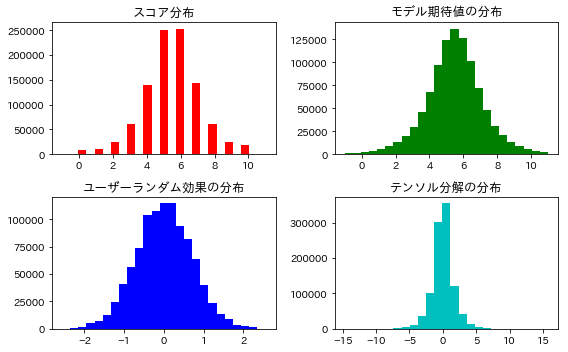

In [8]:
#潜在変数ごとのヒストグラム
dt = [y, mu, beta_d[d_id, ], uv]
fig_range = np.append(np.array([-1.0, -1.0, np.min(beta_d), np.min(uv)]), 
                      np.array([11.0, 11.0, np.max(beta_d), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["スコア分布", "モデル期待値の分布", "ユーザーランダム効果の分布", "テンソル分解の分布"]
fig = plt.figure(figsize=(8.0, 5.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [9]:
####テストデータの作成####
##データの設定
pt0 = np.random.poisson(np.random.gamma(15.0, 1/0.1, hh))
N0 = np.sum(pt0)
m0 = np.random.poisson(2.75, N0)
m0[m0==0] = 1; m0[m0 >= max_m] = max_m
M0 = np.sum(m0)

In [10]:
##idとインデックスの設定
#idの設定
d_id0 = np.repeat(np.arange(hh), pt0)
pt_id0 = np.array(list(itertools.chain(*[np.array(range(pt0[i]), dtype="int") for i in range(hh)])))
m_id0 = np.repeat(np.arange(N0), m0)

#インデックスの設定
freq_m0 = np.repeat(0, hh)
m_index0 = [i for i in range(N0)]
for i in range(hh):
    index = np.array(np.where(d_id0==i)[0], dtype="int")
    freq_m0[i] = np.sum(m0[index])
for i in range(N0):
    if i==0:
        m_index0[i] = np.arange(m0[0])
    else:
        m_index0[i] = np.max(m_index0[i-1]) + np.arange(m0[i]) + 1
freq_id0 = np.repeat(np.arange(hh), freq_m0)

In [11]:
##アイテムの生成
#多項分布からトピックを生成
z = np.array(rmnom(theta_topic[freq_id0, ], M0, topic, np.arange(M0), 0), dtype="int")

#トピックからアイテムを生成
item_long = np.repeat(0, M0)
subject_long = np.repeat(0, M0)
element_long = np.repeat(0, M0)
for j in range(topic):
    index = np.array(np.where(z==j)[0], dtype="int")
    target_z = z[index]
    topic_n = index.shape[0]
    item_long[index] = np.array(rmnom(phi_item[target_z, ], topic_n, item, np.arange(topic_n), 0), dtype="int")
    subject_long[index] = np.array(rmnom(phi_subject[target_z, ], topic_n, subject, np.arange(topic_n), 0), dtype="int")
    element_long[index] = np.array(rmnom(phi_element[target_z, ], topic_n, element, np.arange(topic_n), 0), dtype="int")
gc.collect()

#アイテムをレコードに割当
item_dt0 = np.full((N0, max_m), item, dtype="int16")
subject_dt0 = np.full((N0, max_m), subject, dtype="int16")
element_dt0 = np.full((N0, max_m), element, dtype="int16")
for i in range(N0):
    item_dt0[i, np.arange(m0[i])] = item_long[m_index0[i]]
    subject_dt0[i, np.arange(m0[i])] = subject_long[m_index0[i]]
    element_dt0[i, np.arange(m0[i])] = element_long[m_index0[i]]
    
#一定確率で欠損を挿入
subject_dt0[np.random.binomial(1, 0.5, N0*max_m).reshape(N0, max_m)==1] = subject
element_dt0[np.random.binomial(1, 0.3, N0*max_m).reshape(N0, max_m)==1] = element

#観測インデックスを作成
z_index0 = [j for j in range(max_m)]
item_z0 = [j for j in range(max_m)]
subject_z0 = [j for j in range(max_m)]
element_z0 = [j for j in range(max_m)]
for j in range(max_m):
    z_index0[j] = np.array(np.where(item_dt0[:, j]!=item)[0], dtype="int")
    item_z0[j] = item_dt0[z_index0[j], j]
    subject_z0[j] = subject_dt0[z_index0[j], j]
    element_z0[j] = element_dt0[z_index0[j], j]
del item_dt0, subject_dt0, element_dt0

In [12]:
##応答変数を生成
#期待値を設定
joint_theta = np.zeros((N0, k))
for j in range(max_m):
    index = z_index0[j]
    joint_theta[index, ] += theta_i[item_z0[j], ] * theta_s[subject_z0[j], ] * theta_e[element_z0[j], ]
mu = beta + beta_d[d_id0, ] + np.dot(theta_d[d_id0, ] * joint_theta, np.repeat(1, k))

#正規分布から応答変数を生成
y_full0 = mu + np.random.normal(0, Sigma, N0)
y0 = np.array(np.round(y_full0), dtype="int")
y0[y0 < 0] = 0; y0[y0 >= 10] = 10

In [13]:
####マルコフ連鎖モンテカルロ法でVoTDを推定####
##アルゴリズムの設定
R = 2000
keep = 10
burnin = int(100/keep)
iter = 0
disp = 10

In [14]:
##オブジェクトごとのインデックスと割当配列を設定
#itemのインデックスと割当配列を設定
item_index = [j for j in range(item)]
item_list = [j for j in range(item)]
item_n = np.repeat(0, item)

for j in range(item):
    tmp_index = np.where(item_dt==j)
    index1 = np.array(tmp_index[0], dtype="int")
    index2 = np.array(tmp_index[1], dtype="int")
    n = index1.shape[0]
    item_index[j] = np.unique(index1)
    item_n[j] = item_index[j].shape[0]
    index_row = np.array(scipy.stats.rankdata(index1, method="dense"), dtype="int")
    item_list[j] = np.array(sparse.coo_matrix((np.repeat(1, n), (index_row-1, index2)), 
                                              shape=(item_n[j], max_m)).todense(), dtype="int8")
    
#subjectのインデックスと割当配列を設定
subject_index = [j for j in range(subject)]
subject_list = [j for j in range(subject)]
subject_n = np.repeat(0, subject)

for j in range(subject):
    tmp_index = np.where(subject_dt==j)
    index1 = np.array(tmp_index[0], dtype="int")
    index2 = np.array(tmp_index[1], dtype="int")
    n = index1.shape[0]
    subject_index[j] = np.unique(index1)
    subject_n[j] = subject_index[j].shape[0]
    index_row = np.array(scipy.stats.rankdata(index1, method="dense"), dtype="int")
    subject_list[j] = np.array(sparse.coo_matrix((np.repeat(1, n), (index_row-1, index2)), 
                                              shape=(subject_n[j], max_m)).todense(), dtype="int8")
    
#elementのインデックスと割当配列を設定
element_index = [j for j in range(element)]
element_list = [j for j in range(element)]
element_n = np.repeat(0, element)

for j in range(element):
    tmp_index = np.where(element_dt==j)
    index1 = np.array(tmp_index[0], dtype="int")
    index2 = np.array(tmp_index[1], dtype="int")
    n = index1.shape[0]
    element_index[j] = np.unique(index1)
    element_n[j] = element_index[j].shape[0]
    index_row = np.array(scipy.stats.rankdata(index1, method="dense"), dtype="int")
    element_list[j] = np.array(sparse.coo_matrix((np.repeat(1, n), (index_row-1, index2)), 
                                              shape=(element_n[j], max_m)).todense(), dtype="int8")
    
#リストに格納
object_n = [item_n, subject_n, element_n]
object_index = [item_index, subject_index, element_index]
object_list = [item_list, subject_list, element_list]
del item_n, subject_n, element_n
del item_index, subject_index, element_index
del item_list, subject_list, element_list

In [15]:
##事前分布の設定
#階層モデルの事前分布
gamma = np.array([0])
delta = np.repeat(0, k)
nu = 1
V = 0.1 * np.diag(np.ones(k))
s01 = 0.1
s01 = 0.1

#モデルパラメータの事前分布
tau = 100 
s02 = 1.0
v02 = 1.0

In [16]:
##パラメータの真値
#階層モデルの真値
alpha1 = alphat1.copy()
alpha2 = alphat2.copy()
tau_d = taut_d.copy()
Cov_d = Covt_d.copy(); inv_Cov_d = np.linalg.inv(Cov_d)
Cov_i = Covt_i.copy(); inv_Cov_i = np.linalg.inv(Cov_i)
Cov_s = Covt_s.copy(); inv_Cov_s = np.linalg.inv(Cov_s)
Cov_e = Covt_e.copy(); inv_Cov_e = np.linalg.inv(Cov_e)

#モデルパラメータの真値
Sigma = Sigmat.copy()
beta = betat.copy()
beta_d = betat_d.copy()
theta_d = thetat_d.copy()
theta_i = thetat_i.copy()
theta_s = thetat_s.copy()
theta_e = thetat_e.copy()
theta_i[item, ] = np.repeat(0, k)

#期待値を真値
beta_vec = beta_d[d_id]
joint_theta = np.zeros((N, k))
for j in range(max_m):
    index = z_index[j]
    joint_theta[index, ] += theta_i[item_z[j], ] * theta_s[subject_z[j], ] * theta_e[element_z[j], ]
uv = np.dot(theta_d[d_id, ] * joint_theta, np.repeat(1, k))
mu = beta + beta_vec + uv
mut = mu.copy()

In [17]:
##パラメータの初期値
#階層モデルの初期値
alpha1 = np.array([0.0])
alpha2 = np.repeat(0.0, k)
tau_d = np.array([0.5])
Cov_d = np.diag(np.repeat(0.2, k)); inv_Cov_d = np.linalg.inv(Cov_d)
Cov_i = np.diag(np.repeat(0.2, k)); inv_Cov_i = np.linalg.inv(Cov_i)
Cov_s = np.diag(np.repeat(0.2, k)); inv_Cov_s = np.linalg.inv(Cov_s)
Cov_e = np.diag(np.repeat(0.2, k)); inv_Cov_e = np.linalg.inv(Cov_e)

#モデルパラメータの初期値
Sigma = np.array([0.5])
beta = np.array([np.mean(y)])
beta_d = np.random.normal(alpha1, tau_d, hh)
theta_d = np.random.multivariate_normal(alpha2, Cov_d, hh)
theta_i = np.vstack((np.random.multivariate_normal(alpha2, Cov_i, item), np.repeat(0, k)))
theta_s = np.vstack((np.random.multivariate_normal(alpha2, Cov_s, subject), np.repeat(1, k)))
theta_e = np.vstack((np.random.multivariate_normal(alpha2, Cov_e, element), np.repeat(1, k)))

#期待値を初期値
beta_vec = beta_d[d_id]
joint_theta = np.zeros((N, k))
for j in range(max_m):
    index = z_index[j]
    joint_theta[index, ] += theta_i[item_z[j], ] * theta_s[subject_z[j], ] * theta_e[element_z[j], ]
uv = np.dot(theta_d[d_id, ] * joint_theta, np.repeat(1, k))
mu = beta + beta_vec + uv

In [18]:
##パラメータの格納用配列
#階層モデルのパラメータの格納用配列
TAU_D = np.zeros((int(R/keep)))
COV_D = np.zeros((k, k, int(R/keep)))
COV_I = np.zeros((k, k, int(R/keep)))
COV_S = np.zeros((k, k, int(R/keep)))
COV_E = np.zeros((k, k, int(R/keep)))

#モデルパラメータの格納用配列
SIGMA = np.zeros((int(R/keep)))
BETA = np.zeros((int(R/keep)))
BETA_D = np.zeros((int(R/keep), hh))
THETA_D = np.zeros((hh, k, int(R/keep)))
THETA_I = np.zeros((item, k, int(R/keep)))
THETA_S = np.zeros((subject, k, int(R/keep)))
THETA_E = np.zeros((element, k, int(R/keep)))

In [19]:
##対数尤度の基準値
#学習データに対する1パラメータモデルの対数尤度
LLst = np.sum(scipy.stats.norm.logpdf(y, np.mean(y), np.std(y)))
print(LLst)

#学習データに対する真値での対数尤度
LLbest = np.sum(scipy.stats.norm.logpdf(y, mut, np.std(y - mut)))
print(LLbest)

#テストデータに対する1パラメータモデルの対数尤度
LLst0 = np.sum(scipy.stats.norm.logpdf(y0, np.mean(y0), np.std(y0)))
print(LLst0)

#テストデータに対する真値での対数尤度
joint_theta0 = np.zeros((N0, k))
for j in range(max_m):
    index = z_index0[j]
    joint_theta0[index, ] += thetat_i[item_z0[j], ] * thetat_s[subject_z0[j], ] * thetat_e[element_z0[j], ]
mu0 = betat + betat_d[d_id0] + np.dot(thetat_d[d_id0, ] * joint_theta0, np.repeat(1, k))
LLbest0 = np.sum(scipy.stats.norm.logpdf(y0, mu0, np.std(y0 - mu0)))
print(LLbest0)

-1954024.5395407642
-511645.2710131897
-1467919.7282956662
-384712.2138471043


In [ ]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##モデルの期待値パラメータと標準偏差をサンプリング
    #データの設定
    Sigma_sq = np.power(Sigma, 2)
    er_y = y - beta_vec - uv

    #正規分布から期待値をサンプリング
    weights = np.power(tau, 2) / (Sigma_sq/N + np.power(tau, 2))
    mu_par = weights * np.mean(er_y)
    beta = np.random.normal(mu_par, weights*Sigma_sq/N, 1)
    beta = betat.copy()


    #逆ガンマ分布から標準偏差をサンプリング
    er_y = y - beta - beta_vec - uv
    s1 = np.sum(np.power(er_y, 2)) + s01
    s2 = N + s02
    Sigma = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))

    ##ユーザーのランダム効果をサンプリング
    #モデル誤差を定義
    er_y = y - beta - uv

    #正規分布から事後分布をサンプリング
    weights = np.repeat(0.0, hh)
    mu_par = np.repeat(0.0, hh)
    for i in range(hh):
        index = d_index[i]
        weights[i] = np.power(tau_d, 2) / (Sigma_sq/pt[i] + np.power(tau_d, 2))
        mu_par[i] = weights[i] * np.mean(er_y[index]) 
    beta_d = np.random.normal(mu_par, weights*Sigma_sq/pt)
    beta_vec = beta_d[d_id]


    ##ユーザーの特徴ベクトルをサンプリング
    #モデル誤差を定義
    er_y = y - beta - beta_vec

    for i in range(hh):
        #事後分布のパラメータ
        index = d_index[i]
        x1 = joint_theta[index, ]; y1 = er_y[index]
        xy = np.dot(x1.T, y1)
        xxv = np.dot(x1.T, x1) + inv_Cov_d
        inv_xxv = np.linalg.inv(xxv)
        theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov_d, alpha2))

        #多変量正規分布からパラメータをサンプリング
        theta_d[i, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
    theta_vec = theta_d[d_id, ]


    ##オブジェクトごとの特徴ベクトルをサンプリング
    #パラメータをリストに格納
    theta_list = [theta_i, theta_s, theta_e]
    inv_Cov = [inv_Cov_i, inv_Cov_s, inv_Cov_e]

    for i in range(len(type_n)):
        #リストからオブジェクトを抽出
        n = object_n[i]
        g_index = object_index[i]
        g_list = object_list[i]
        theta_tmp = np.zeros((type_n[i], k))

        for j1 in range(type_n[i]):
            #データの設定
            except_dt = np.zeros((n[j1], max_m))
            x1 = np.zeros((n[j1], k))
            index = g_index[j1]; z = g_list[j1]

            #オブジェクトのインデックスを抽出
            index1 = item_dt[index, ]
            index2 = subject_dt[index, ]
            index3 = element_dt[index, ]

            #推定対象のパラメータを除去
            theta_fixed = theta_vec[g_index[j1], ]
            for j2 in range(max_m):
                tmp_dt = theta_i[index1[:, j2] , ] * theta_s[index2[:, j2], ] * theta_e[index3[:, j2], ]
                except_dt[:, j2] = np.dot(tmp_dt * theta_fixed, k_vec)
                x1 += z[:, j2][:, np.newaxis] * tmp_dt
            except_dt = np.dot((1-z) * except_dt, m_vec)
            x1 = x1 / theta_list[i][j1, ] * theta_fixed

            #事後分布のパラメータ
            y1 = er_y[index] - except_dt
            xy = np.dot(x1.T, y1) 
            xxv = np.dot(x1.T, x1) + inv_Cov[i]
            inv_xxv = np.linalg.inv(xxv)
            theta_par = np.dot(inv_xxv, xy + np.dot(inv_Cov[i], alpha2))

            #多変量正規分布から事後分布をサンプリング
            if i==0:
                theta_i[j1, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            elif i==1:
                theta_s[j1, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)
            else:
                theta_e[j1, ] = np.random.multivariate_normal(theta_par, Sigma_sq*inv_xxv, 1)

        #リストに格納
        theta_list = [theta_i, theta_s, theta_e]

    #期待値を更新
    joint_theta = np.zeros((N, k))
    for j in range(max_m):
        index = z_index[j]
        joint_theta[index, ] += theta_i[item_z[j], ] * theta_s[subject_z[j], ] * theta_e[element_z[j], ]
    uv = np.dot(theta_d[d_id, ] * joint_theta, np.repeat(1, k))
    mu = beta + beta_vec + uv


    ##階層モデルのパラメータをサンプリング
    #ランダム効果の分散をサンプリング
    er_d = beta_d - np.mean(beta_d)
    s1 = np.sum(np.power(er_d, 2)) + s01
    s2 = hh + s02
    tau_d = np.sqrt(1/np.random.gamma(s2/2, 1/(s1/2), 1))

    #ユーザーの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_d - np.mean(theta_d, axis=0)
    IW_R = np.dot(er.T, er) + V
    Sn = hh + nu
    Cov_d = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_d = np.linalg.inv(Cov_d)

    #itemの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_i[:item, ] - np.mean(theta_i[:item, ], axis=0)
    IW_R = np.dot(er.T, er) + V
    Sn = item + nu
    Cov_i = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_i = np.linalg.inv(Cov_i)

    #subjectの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_s[:subject, ] - np.mean(theta_s[:subject, ], axis=0)
    IW_R = np.dot(er.T, er) + V
    Sn = subject + nu
    Cov_s = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_s = np.linalg.inv(Cov_s)

    #elementの特徴ベクトルの分散共分散行列をサンプリング
    er = theta_e[:element, ] - np.mean(theta_e[:element, ], axis=0)
    IW_R = np.dot(er.T, er) + V
    Sn = element + nu
    Cov_e = np.diag(np.diag(scipy.stats.invwishart.rvs(Sn, IW_R, 1)))
    inv_Cov_e = np.linalg.inv(Cov_e)


    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)
        TAU_D[mkeep] = tau_d
        COV_D[:, :, mkeep] = Cov_d
        COV_I[:, :, mkeep] = Cov_i
        COV_S[:, :, mkeep] = Cov_s
        COV_E[:, :, mkeep] = Cov_e

        #モデルパラメータの格納用配列
        SIGMA[mkeep] = Sigma
        BETA[mkeep] = beta
        BETA_D[mkeep, ] = beta_d
        THETA_D[:, :, mkeep] = theta_d
        THETA_I[:, :, mkeep] = theta_i[:item, ]
        THETA_S[:, :, mkeep] = theta_s[:subject, ]
        THETA_E[:, :, mkeep] = theta_e[:element, ]
    
    if rp%disp==0:
        #学習データに対する対数尤度を更新
        LL = np.sum(scipy.stats.norm.logpdf(y, mu, Sigma))

        #テストデータに対する対数尤度を更新
        joint_theta0 = np.zeros((N0, k))
        for j in range(max_m):
            index = z_index0[j]
            joint_theta0[index, ] += theta_i[item_z0[j], ] * theta_s[subject_z0[j], ] * theta_e[element_z0[j], ]
        mu0 = beta + beta_d[d_id0] + np.dot(theta_d[d_id0, ] * joint_theta0, np.repeat(1, k))
        LL0 = np.sum(scipy.stats.norm.logpdf(y0, mu0, Sigma))
        
        #サンプリング結果の表示
        print(rp)
        print(np.round(np.array((LL, LLbest, LLst)), 1))
        print(np.round(np.array((LL0, LLbest0, LLst0)), 1))
        print(np.round(np.array([Sigma, Sigmat]).reshape(-1), 3))

0
[-1848508.5  -511645.3 -1954024.5]
[-1443995.3  -384712.2 -1467919.7]
[1.875 0.2  ]
10
[ -660504.1  -511645.3 -1954024.5]
[ -582275.8  -384712.2 -1467919.7]
[0.523 0.2  ]
20
[ -463042.4  -511645.3 -1954024.5]
[ -454575.3  -384712.2 -1467919.7]
[0.385 0.2  ]
30
[ -463285.9  -511645.3 -1954024.5]
[ -455057.2  -384712.2 -1467919.7]
[0.385 0.2  ]
40
[ -462899.9  -511645.3 -1954024.5]
[ -454252.3  -384712.2 -1467919.7]
[0.385 0.2  ]
50
[ -462602.   -511645.3 -1954024.5]
[ -453026.9  -384712.2 -1467919.7]
[0.386 0.2  ]
60
[ -462893.5  -511645.3 -1954024.5]
[ -453740.9  -384712.2 -1467919.7]
[0.385 0.2  ]
70
[ -462979.8  -511645.3 -1954024.5]
[ -454966.6  -384712.2 -1467919.7]
[0.385 0.2  ]
80
[ -462694.5  -511645.3 -1954024.5]
[ -453446.3  -384712.2 -1467919.7]
[0.386 0.2  ]
90
[ -463066.6  -511645.3 -1954024.5]
[ -454459.8  -384712.2 -1467919.7]
[0.385 0.2  ]
100
[ -463050.7  -511645.3 -1954024.5]
[ -454815.3  -384712.2 -1467919.7]
[0.385 0.2  ]
110
[ -462852.7  -511645.3 -1954024.5]
[ -4